In [1]:
import raw_data
import ta

import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("msft")
prediction_period = 30  # predict 30 days in the future

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5.960000e+03,5960.000000,5960.000000
mean,55.470969,56.162841,54.785379,55.494916,26.638197,4.237067e+07,0.002562,1.000671
std,34.166645,34.658273,33.658528,34.197385,18.961481,3.046236e+07,0.046281,0.025900
min,15.200000,15.620000,14.870000,15.150000,2.423500,7.111000e+05,0.000000,1.000000
25%,27.417500,27.710000,27.210000,27.457500,17.478850,2.185800e+07,0.000000,1.000000
50%,43.980000,44.500000,43.555000,43.990000,21.428700,3.814835e+07,0.000000,1.000000
75%,77.597500,79.025000,76.690000,77.690000,28.917300,5.712868e+07,0.000000,1.000000
max,178.940000,180.380000,175.750000,179.940000,112.330000,5.910522e+08,3.080000,2.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,111.685,112.777,111.515,112.33,112.33,23216875,0.0,1.0
1,2018-08-30,111.670,112.610,111.440,111.95,111.95,22798702,0.0,1.0
2,2018-08-29,110.450,112.030,110.270,112.02,112.02,20818044,0.0,1.0
3,2018-08-28,109.940,110.500,109.790,110.26,110.26,19151528,0.0,1.0
4,2018-08-27,109.270,109.640,108.510,109.60,109.60,19662331,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, means=None, stds=None):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days
    processed_df = selected_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    processed_df = processed_df.drop("volatility_kchi", axis=1)

    if means is None:
        means = processed_df.mean().copy()
    if stds is None:
        stds = processed_df.std().copy()

    # Normalize features
    processed_df = (processed_df - means) / stds
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes
        
    return processed_df, means, stds

In [4]:
def preprocess_features(df):
    processed_features = df.iloc[:, df.columns != "future_change"].copy()
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_change"].copy()
    return processed_targets

In [5]:
df, means, stds = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
df = df.sample(frac=1)  # Shuffle df

display.display(df.describe())
display.display(df.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_change
count,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,...,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5.930000e+03,5930.000000
mean,5.070855e-15,6.302622e-15,8.270094e-15,5.102607e-15,3.594651e-17,5.703513e-16,-5.991085e-18,2.396434e-18,1.835669e-15,5.991085e-18,...,-2.912866e-15,-4.912690e-17,-2.377263e-15,3.355008e-16,-2.862541e-15,-1.078395e-17,1.617593e-17,-9.585737e-18,9.890683e-15,0.024045
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.099083
min,-1.175037e+00,-1.166050e+00,-1.182378e+00,-1.315315e+00,-1.369035e+00,-7.782110e+00,-1.137025e+01,-4.317744e+00,-5.313835e+00,-3.662566e+01,...,-6.729928e+00,-6.461059e+00,-7.143444e+00,-6.911655e+00,-7.143444e+00,-3.175922e+00,-8.214181e+00,-8.971041e+00,-1.315315e+00,-0.411349
25%,-8.169001e-01,-8.171005e-01,-8.146773e-01,-4.840935e-01,-6.709609e-01,-4.600725e-01,-7.224421e-01,-4.813023e-01,-5.577503e-01,-4.732978e-02,...,-7.327126e-01,-1.827355e-01,-4.702840e-01,-4.748390e-01,-4.702840e-01,-2.252368e-01,-4.776289e-01,-4.706525e-01,-4.840935e-01,-0.035985
50%,-3.381844e-01,-3.390233e-01,-3.374561e-01,-2.672278e-01,-1.381068e-01,1.880375e-01,-3.782082e-02,-1.171538e-02,1.850690e-01,1.282417e-02,...,-2.514227e-02,-6.435620e-02,2.415049e-01,2.393940e-01,2.415049e-01,-3.235557e-02,8.471738e-03,1.841538e-02,-2.672278e-01,0.022496
75%,5.988323e-01,5.931731e-01,6.107239e-01,1.269919e-01,4.839479e-01,7.704783e-01,7.359585e-01,4.393195e-01,7.575758e-01,6.439506e-02,...,7.655157e-01,5.410997e-03,7.385192e-01,7.400710e-01,7.385192e-01,1.672982e-01,4.632927e-01,4.717511e-01,1.269919e-01,0.078095
max,3.634590e+00,3.604155e+00,3.615331e+00,4.400546e+00,1.798424e+01,1.259024e+00,6.147545e+00,7.321329e+00,1.373777e+00,1.827160e+01,...,2.469971e+00,8.430045e+00,1.314746e+00,1.301864e+00,1.314746e+00,1.244431e+01,9.325830e+00,8.576996e+00,4.400546e+00,0.492531


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_change
5427,1.267962,1.291434,1.281786,-0.993584,-1.136441,0.784885,0.153277,-0.014452,-1.649725,-0.002111,...,-0.439611,-0.055833,-2.253700,-2.346120,-2.253700,0.252790,1.370198,1.363693,-0.993584,-0.102116
712,-0.066773,-0.043564,-0.048260,1.344883,-0.192582,0.989705,-0.701146,0.295201,1.050324,-0.019936,...,0.503204,0.136394,0.824716,0.852106,0.824716,-0.022657,-0.209226,-0.200024,1.344883,0.043610
4857,0.695178,0.696171,0.659110,-0.053348,-0.008879,-0.204209,-0.808973,0.156416,-0.353885,-0.170953,...,-0.547688,-0.065095,-1.651890,-1.617272,-1.651890,-0.404338,-1.408663,-1.420841,-0.053348,0.128528
5266,2.299856,2.283055,2.336877,-0.838642,-1.279631,0.800306,0.069230,-0.036018,-1.972876,0.006594,...,0.144734,-0.064084,-3.166335,-2.555949,-3.166335,0.036609,0.854641,0.858582,-0.838642,-0.032038
821,-0.239195,-0.235229,-0.235541,0.971936,-0.446966,1.048875,0.557973,1.297943,1.007394,0.021888,...,0.533449,0.286599,0.930230,0.916890,0.930230,0.209704,0.354379,0.363564,0.971936,-0.034088


In [6]:
num_rows = len(df)
# Use 90% for training and rest for validation
num_training = int(num_rows * 0.9)
num_validation = num_rows - num_training

training_examples = preprocess_features(df.head(num_training))
training_targets = preprocess_targets(df.head(num_training))

validation_examples = preprocess_features(df.tail(num_validation))
validation_targets = preprocess_targets(df.tail(num_validation))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,...,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000,5337.000000
mean,-0.002665,-0.002452,-0.002411,-0.003087,-0.003609,-0.000916,0.002354,-0.001402,-0.002115,0.005105,...,-0.000832,-0.000744,-0.000006,-0.003451,-0.002419,-0.003451,0.002527,-0.001544,-0.001597,-0.003087
std,0.997433,0.997753,0.997648,0.995224,0.993377,0.997915,0.995988,0.998802,1.002241,1.026152,...,0.997566,1.003875,1.006495,1.001927,0.999965,1.001927,0.989909,1.002005,1.002820,0.995224
min,-1.175037,-1.166050,-1.182378,-1.315315,-1.369035,-7.782110,-11.370252,-4.317744,-5.313835,-36.625661,...,-3.148711,-6.729928,-6.461059,-7.143444,-6.911655,-7.143444,-3.159639,-8.214181,-8.971041,-1.315315
25%,-0.816092,-0.815725,-0.814081,-0.484098,-0.665634,-0.460087,-0.721131,-0.481133,-0.566471,-0.045075,...,-0.712925,-0.733087,-0.183811,-0.476675,-0.474871,-0.476675,-0.226716,-0.478624,-0.471658,-0.484098
50%,-0.334660,-0.337720,-0.334847,-0.265048,-0.139753,0.182916,-0.039302,-0.012096,0.189146,0.012957,...,0.013821,-0.026938,-0.064360,0.238560,0.238739,0.238560,-0.031532,0.007284,0.017226,-0.265048
75%,0.584733,0.578335,0.590221,0.116437,0.477273,0.768571,0.735554,0.429914,0.757238,0.066667,...,0.694137,0.770562,0.004597,0.735740,0.738123,0.735740,0.170022,0.461999,0.470467,0.116437
max,3.511515,3.594890,3.518411,4.400546,17.984242,1.259024,6.147545,7.321329,1.373777,18.271598,...,3.376649,2.469971,8.430045,1.310949,1.301864,1.310949,12.444313,9.325830,8.576996,4.400546


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,...,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.023981,0.022066,0.021695,0.027785,0.032483,0.008241,-0.021185,0.012615,0.019035,-0.045947,...,0.007486,0.006694,0.000056,0.031061,0.021769,0.031061,-0.022741,0.013894,0.014370,0.027785
std,1.023357,1.020595,1.021524,1.042462,1.058068,1.019394,1.036034,1.011486,0.980230,0.722313,...,1.022474,0.965220,0.940333,0.982774,1.000900,0.982774,1.087246,0.982496,0.974961,1.042462
min,-1.121871,-1.124937,-1.134366,-1.310778,-1.334071,-6.732234,-5.418716,-3.400213,-3.922700,-10.171881,...,-2.736965,-3.169581,-2.923860,-5.026584,-5.293713,-5.026584,-3.175922,-3.144698,-3.241946,-1.310778
25%,-0.822261,-0.824411,-0.821834,-0.482086,-0.711256,-0.458621,-0.729507,-0.504267,-0.503984,-0.067117,...,-0.677197,-0.720122,-0.162977,-0.385256,-0.473009,-0.385256,-0.217298,-0.462855,-0.455718,-0.482086
50%,-0.364033,-0.368410,-0.370334,-0.293026,-0.108565,0.224091,0.003070,-0.007505,0.154100,0.010768,...,0.036888,-0.013921,-0.064310,0.273231,0.250318,0.273231,-0.034975,0.021947,0.031905,-0.293026
75%,0.848214,0.833985,0.858318,0.225937,0.553740,0.785024,0.755212,0.540227,0.765422,0.050352,...,0.741386,0.712072,0.013084,0.762243,0.746828,0.762243,0.148727,0.475645,0.484007,0.225937
max,3.634590,3.604155,3.615331,4.192471,8.053191,1.251330,5.547243,3.649346,1.373777,5.118105,...,3.377060,2.329942,8.430045,1.314746,1.287946,1.314746,10.224906,8.537078,7.906252,4.192471


Training targets summary:


count    5337.000000
mean        0.023704
std         0.099180
min        -0.411349
25%        -0.036775
50%         0.022287
75%         0.078653
max         0.440145
Name: future_change, dtype: float64

Validation targets summary:


count    593.000000
mean       0.027118
std        0.098229
min       -0.355253
25%       -0.028296
50%        0.022874
75%        0.073520
max        0.492531
Name: future_change, dtype: float64

In [7]:
display.display(validation_examples.head(5))
display.display(validation_targets.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
344,0.307447,0.312841,0.326001,2.115987,-0.326150,1.104971,-0.622747,-0.405535,1.177525,-0.099291,...,-0.615791,-0.606979,-2.536219,0.993816,0.919795,0.993816,-0.266579,-0.819890,-0.817875,2.115987
5621,1.683011,1.696768,1.658135,-1.197575,-1.238059,0.928327,-0.087491,-0.031758,-3.198953,0.008234,...,-0.434780,-0.392082,-0.066226,-1.873781,-2.028479,-1.873781,-0.973404,-0.373726,-0.365715,-1.197575
1122,-0.468603,-0.441399,-0.455624,0.551138,0.550708,0.668279,1.143570,0.289424,0.959887,-0.047151,...,0.395512,-0.018669,-0.251297,0.704004,0.721079,0.704004,0.044130,0.234936,0.244650,0.551138
668,-0.073529,-0.069766,-0.073012,1.261013,0.462031,0.926300,-1.085379,0.183480,1.176936,-0.058767,...,0.190747,0.248060,0.438350,1.054072,1.071513,1.054072,0.167438,-0.131865,-0.122291,1.261013
5624,1.686535,1.660577,1.710323,-1.192176,-1.334071,0.919216,-0.031135,-0.061173,-2.846546,0.005689,...,0.308110,-0.430190,-0.061431,-1.871055,-1.894201,-1.871055,-0.828868,-0.795179,-0.792725,-1.192176


344     0.094670
5621    0.123998
1122   -0.015871
668     0.016312
5624    0.103766
Name: future_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.040
  period 01 : 0.033
  period 02 : 0.032
  period 03 : 0.031
  period 04 : 0.030
  period 05 : 0.030
  period 06 : 0.029
  period 07 : 0.029
  period 08 : 0.028
  period 09 : 0.028
Model training finished.
Final RMSE (on training data):   0.028
Final RMSE (on validation data): 0.032


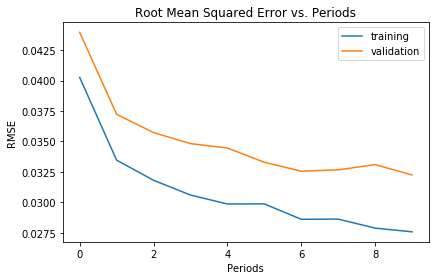

In [11]:
regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.04),
    steps=1500,
    batch_size=30,
    hidden_units=[30, 30, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

(59, 30)
Darker corresponds to more negative, lighter corresponds to more positive.


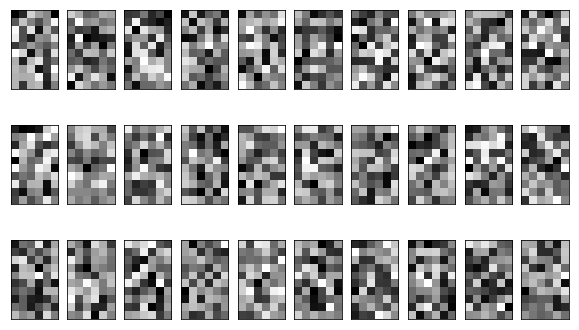

In [12]:
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
print(weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    padded = np.pad(coef, (0, 1), "constant")
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

print("Darker corresponds to more negative, lighter corresponds to more positive.")
plt.show()

In [13]:
recent_df, _, _ = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, means, stds)
recent_features = preprocess_features(recent_df).head(prediction_period)
recent_targets = preprocess_targets(recent_df).head(prediction_period)
predict_recent_input_fn = lambda: input_fn(recent_features, recent_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_recent_input_fn)
predictions = [item["predictions"][0] for item in predictions]
display.display(predictions)

[0.01574213,
 0.066142306,
 0.05817975,
 0.066578455,
 0.06680882,
 0.06773069,
 0.068129964,
 0.067809775,
 0.06848556,
 0.06159847,
 0.04893691,
 0.052117687,
 0.051022857,
 0.020405551,
 0.03758175,
 0.030468881,
 0.020135166,
 0.021220714,
 0.025452534,
 0.036616653,
 0.033280753,
 0.03478076,
 0.0154944435,
 0.012466952,
 0.01862159,
 0.031494886,
 0.0011069849,
 -0.01660489,
 0.033667,
 0.03248003]